In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [18]:
import utils_generic as generic
import st_simple as st
import model_confs as confs


import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.distilbert_conf

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,['about','to','as'],model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,['about','to','as'],model_conf) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskSimple(convai_train_token,task,eval=False)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskSimple(convai_val_token,task,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset(md_data,['about','to','as'],model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskSimple(md_tokenized,task,eval=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [14]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [15]:
model = st.SingleTaskSimple(model_conf,num_labels=2).to(device)
save_path='simple_distilbert_about'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5547048580874965 	 Validation loss: 0.3958538093809354 	 
  1%|          | 574/57400 [02:31<2:54:31,  5.43it/s]
Epoch 2 	 Training loss: 0.37728413165861724 	 Validation loss: 0.350276618438252 	 
  2%|▏         | 1148/57400 [04:43<3:32:00,  4.42it/s]
Epoch 3 	 Training loss: 0.3452201861278105 	 Validation loss: 0.33550176150717975 	 
  3%|▎         | 1722/57400 [06:56<3:26:49,  4.49it/s]
Epoch 4 	 Training loss: 0.32971573885828775 	 Validation loss: 0.32847665881706495 	 
  4%|▍         | 2296/57400 [09:08<3:23:04,  4.52it/s]
Epoch 5 	 Training loss: 0.317021179230371 	 Validation loss: 0.32001266615875695 	 
  5%|▌         | 2870/57400 [11:21<3:28:37,  4.36it/s]
Epoch 6 	 Training loss: 0.3067254467967911 	 Validation loss: 0.31469076619309894 	 
  6%|▌         | 3444/57400 [13:34<3:24:22,  4.40it/s]
Epoch 7 	 Training loss: 0.29549070891602947 	 Validation loss: 0.31021293846227355 	 
  7%|▋         | 4018/57400 [15:46<2:44:52,  5.40it/s]
Epoch 8 	 Train

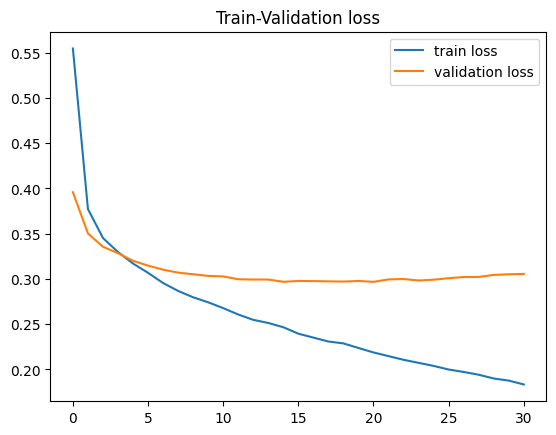

In [16]:
model = st.SingleTaskSimple(model_conf,num_labels=2).to(device)
save_path='simple_distilbert_about'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [19]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8525, 'male': 0.8229166666666666, 'average': 0.8377083333333333}
precision {'female': 0.8337408312958435, 'male': 0.8426666666666667, 'average': 0.838203748981255}
f1 {'female': 0.8430160692212608, 'male': 0.8326745718050066, 'average': 0.8378453205131338}
accuracy 0.8380102040816326


Evaluación en el conjunto el conjunto to
recall {'female': 0.6614173228346457, 'male': 0.6496350364963503, 'average': 0.6555261796654981}
precision {'female': 0.6363636363636364, 'male': 0.6742424242424242, 'average': 0.6553030303030303}
f1 {'female': 0.6486486486486487, 'male': 0.6617100371747211, 'average': 0.6551793429116849}
accuracy 0.6553030303030303


Evaluación en el conjunto el conjunto as
recall {'female': 0.7196765498652291, 'male': 0.6439393939393939, 'average': 0.6818079719023116}
precision {'female': 0.6544117647058824, 'male': 0.7103064066852368, 'average': 0.6823590856955596}
f1 {'female': 0.6854942233632864, 'male': 0.6754

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5930257853938312 	 Validation loss: 0.43779620780783185 	 
  1%|          | 574/57400 [02:08<3:32:54,  4.45it/s]
Epoch 2 	 Training loss: 0.4010607109304504 	 Validation loss: 0.3576643537666838 	 
  2%|▏         | 1148/57400 [04:17<3:26:37,  4.54it/s]
Epoch 3 	 Training loss: 0.3561752946846161 	 Validation loss: 0.33912186652927073 	 
  3%|▎         | 1722/57400 [06:23<3:11:13,  4.85it/s]
Epoch 4 	 Training loss: 0.33584711991432237 	 Validation loss: 0.3281718601109618 	 
  4%|▍         | 2296/57400 [08:29<3:18:27,  4.63it/s]
Epoch 5 	 Training loss: 0.32177426938603565 	 Validation loss: 0.3218313008546829 	 
  5%|▌         | 2870/57400 [10:34<3:19:00,  4.57it/s]
Epoch 6 	 Training loss: 0.30929416659505526 	 Validation loss: 0.31491332539057326 	 
  6%|▌         | 3444/57400 [12:40<3:08:56,  4.76it/s]
Epoch 7 	 Training loss: 0.300444202556012 	 Validation loss: 0.3107484584137545 	 
  7%|▋         | 4018/57400 [14:44<3:07:23,  4.75it/s]
Epoch 8 	 Traini

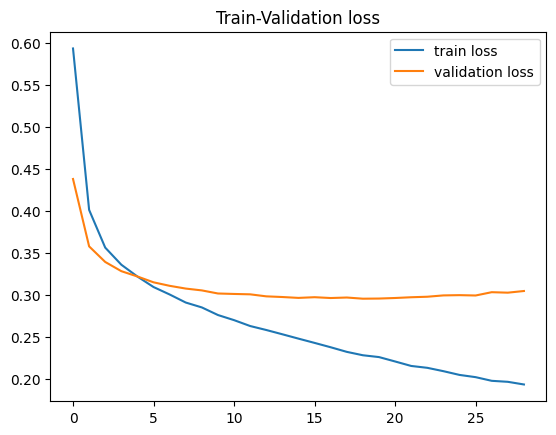

In [20]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [21]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8425, 'male': 0.8359375, 'average': 0.83921875}
precision {'female': 0.8425, 'male': 0.8359375, 'average': 0.83921875}
f1 {'female': 0.8425, 'male': 0.8359375, 'average': 0.83921875}
accuracy 0.8392857142857143


Evaluación en el conjunto el conjunto to
recall {'female': 0.6692913385826772, 'male': 0.656934306569343, 'average': 0.6631128225760101}
precision {'female': 0.6439393939393939, 'male': 0.6818181818181818, 'average': 0.6628787878787878}
f1 {'female': 0.6563706563706564, 'male': 0.6691449814126393, 'average': 0.6627578188916479}
accuracy 0.6628787878787878


Evaluación en el conjunto el conjunto as
recall {'female': 0.7142857142857143, 'male': 0.6464646464646465, 'average': 0.6803751803751804}
precision {'female': 0.654320987654321, 'male': 0.7071823204419889, 'average': 0.680751654048155}
f1 {'female': 0.6829896907216496, 'male': 0.6754617414248021, 'average': 0.6792257160732258}
accuracy 0.6792698826597132


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5536077167410468 	 Validation loss: 0.3982053530418267 	 
  1%|          | 574/57400 [02:04<3:24:24,  4.63it/s]
Epoch 2 	 Training loss: 0.38168264611361336 	 Validation loss: 0.35084394681251657 	 
  2%|▏         | 1148/57400 [04:09<3:16:25,  4.77it/s]
Epoch 3 	 Training loss: 0.3502039414041964 	 Validation loss: 0.3349538081783359 	 
  3%|▎         | 1722/57400 [06:13<3:22:39,  4.58it/s]
Epoch 4 	 Training loss: 0.3320485264166722 	 Validation loss: 0.3257365509615106 	 
  4%|▍         | 2296/57400 [08:18<3:08:03,  4.88it/s]
Epoch 5 	 Training loss: 0.31827237368772254 	 Validation loss: 0.3201332428192688 	 
  5%|▌         | 2870/57400 [10:22<2:36:09,  5.82it/s]
Epoch 6 	 Training loss: 0.3086604845129239 	 Validation loss: 0.31576446532192876 	 
  6%|▌         | 3444/57400 [12:26<3:07:54,  4.79it/s]
Epoch 7 	 Training loss: 0.2990207138636802 	 Validation loss: 0.3143940297728878 	 
  7%|▋         | 4018/57400 [14:31<3:06:54,  4.76it/s]
Epoch 8 	 Trainin

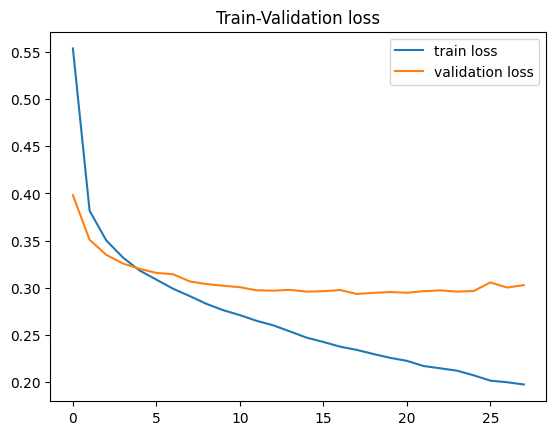

In [22]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [23]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.845, 'male': 0.8359375, 'average': 0.84046875}
precision {'female': 0.8428927680798005, 'male': 0.8381201044386423, 'average': 0.8405064362592214}
f1 {'female': 0.8439450686641697, 'male': 0.8370273794002607, 'average': 0.8404862240322153}
accuracy 0.8405612244897959


Evaluación en el conjunto el conjunto to
recall {'female': 0.6561679790026247, 'male': 0.656934306569343, 'average': 0.6565511427859838}
precision {'female': 0.639386189258312, 'male': 0.6733167082294265, 'average': 0.6563514487438693}
f1 {'female': 0.6476683937823834, 'male': 0.665024630541872, 'average': 0.6563465121621277}
accuracy 0.6565656565656566


Evaluación en el conjunto el conjunto as
recall {'female': 0.7196765498652291, 'male': 0.6565656565656566, 'average': 0.6881211032154428}
precision {'female': 0.6625310173697271, 'male': 0.7142857142857143, 'average': 0.6884083658277207}
f1 {'female': 0.689922480620155, 'male': 0.6842105263157894, 'averag

Resultados finales

In [24]:

print('f1 medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global F1:',mean(global_metrics[task]['f1']['average']))
    print(f'F1 etiqueta male:',mean(global_metrics[task]['f1']['male']))
    print('F1 etiqueta female: ',mean(global_metrics[task]['f1']['female']))

f1 medio de los 3 modelos: 


 about
Resultado global F1: 0.8391834315151163
F1 etiqueta male: 0.8352131504017558
F1 etiqueta female:  0.8431537126284768

 to
Resultado global F1: 0.6580945579884868
F1 etiqueta male: 0.6652932163764108
F1 etiqueta female:  0.6508958996005628

 as
Resultado global F1: 0.682262558531234
F1 etiqueta male: 0.6783896521607711
F1 etiqueta female:  0.686135464901697


In [34]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.8391834315151163
f1 etiqueta male: 0.8352131504017558
f1 etiqueta female:  0.8431537126284768


TO
Resultado global f1: 0.6580945579884868
f1 etiqueta male: 0.6652932163764108
f1 etiqueta female:  0.6508958996005628


AS
Resultado global f1: 0.682262558531234
f1 etiqueta male: 0.6783896521607711
f1 etiqueta female:  0.686135464901697


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.8391834315151163
recall etiqueta male: 0.8352131504017558
recall etiqueta female:  0.8431537126284768


TO
Resultado global recall: 0.6580945579884868
recall etiqueta male: 0.6652932163764108
recall etiqueta female:  0.6508958996005628


AS
Resultado global recall: 0.682262558531234
recall etiqueta male: 0.6783896521607711
recall etiqueta female:  0.686135464901697


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.8391834315151163
precision etiqueta male: 0.8352131504017558
precision etiqueta female:  0.84315

# TO

In [35]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6956167634355898 	 Validation loss: 0.6927855307773009 	 
  1%|          | 574/57400 [02:25<3:43:31,  4.24it/s]
Epoch 2 	 Training loss: 0.6948103890186403 	 Validation loss: 0.6929857387381085 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [05:25<4:53:01,  3.20it/s]
Epoch 3 	 Training loss: 0.6944992461270987 	 Validation loss: 0.6941192261243271 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [08:33<5:06:26,  3.03it/s]
Epoch 4 	 Training loss: 0.6938271046930905 	 Validation loss: 0.6927492669073202 	 
  4%|▍         | 2296/57400 [11:48<4:12:15,  3.64it/s]
Epoch 5 	 Training loss: 0.6933239979818723 	 Validation loss: 0.693621315188327 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [15:03<5:18:55,  2.85it/s]
Epoch 6 	 Training loss: 0.6935329829774252 	 Validation loss: 0.6947542499687712 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [18:18<4:52:33,  3.07it/s]
Epoch 7 	 Training loss: 0.693709451043232 	 V

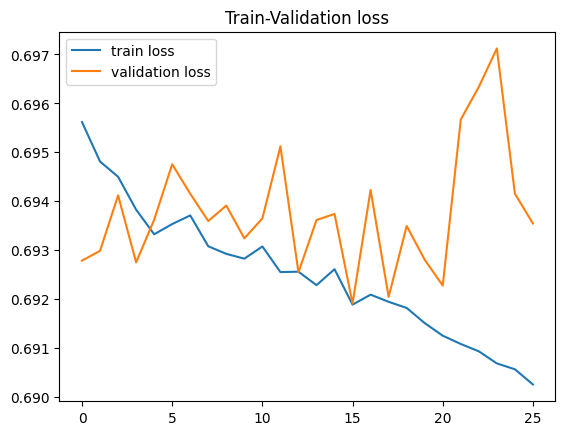

In [36]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [37]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.6525, 'male': 0.515625, 'average': 0.5840624999999999}
precision {'female': 0.5838926174496645, 'male': 0.5875370919881305, 'average': 0.5857148547188975}
f1 {'female': 0.6162927981109799, 'male': 0.5492371705963939, 'average': 0.5827649843536868}
accuracy 0.5854591836734694


Evaluación en el conjunto el conjunto to
recall {'female': 0.5669291338582677, 'male': 0.5644768856447688, 'average': 0.5657030097515183}
precision {'female': 0.5468354430379747, 'male': 0.5843828715365239, 'average': 0.5656091572872493}
f1 {'female': 0.556701030927835, 'male': 0.5742574257425742, 'average': 0.5654792283352046}
accuracy 0.5656565656565656


Evaluación en el conjunto el conjunto as
recall {'female': 0.6388140161725068, 'male': 0.5404040404040404, 'average': 0.5896090282882736}
precision {'female': 0.5656324582338902, 'male': 0.6149425287356322, 'average': 0.5902874934847612}
f1 {'female': 0.6, 'male': 0.5752688172043011, 'average': 

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6966489416381624 	 Validation loss: 0.69446954080614 	 
  1%|          | 574/57400 [02:11<3:39:43,  4.31it/s]
Epoch 2 	 Training loss: 0.6949016546330801 	 Validation loss: 0.6910128361087734 	 
  2%|▏         | 1148/57400 [04:23<3:37:39,  4.31it/s]
Epoch 3 	 Training loss: 0.6942596467737537 	 Validation loss: 0.6932403212886745 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [06:35<3:27:47,  4.47it/s]
Epoch 4 	 Training loss: 0.6937479614588442 	 Validation loss: 0.6948850356926353 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [08:47<3:26:11,  4.45it/s]
Epoch 5 	 Training loss: 0.693867012391107 	 Validation loss: 0.6933430099891404 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [10:59<3:26:49,  4.39it/s]
Epoch 6 	 Training loss: 0.6934533305076772 	 Validation loss: 0.6940176345534244 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [13:10<3:24:41,  4.39it/s]
Epoch 7 	 Training loss: 0.6931933733644385 	 Va

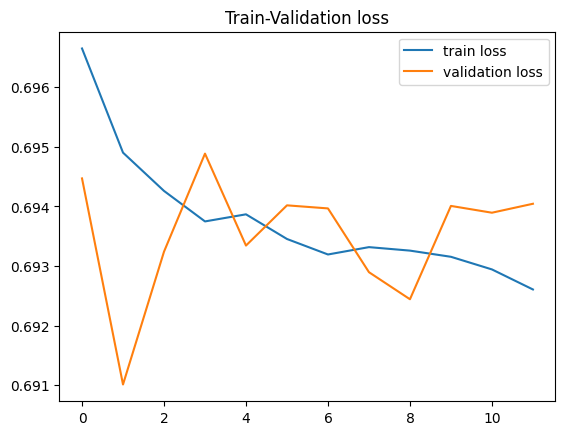

In [38]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_to2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [39]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8575, 'male': 0.17447916666666666, 'average': 0.5159895833333333}
precision {'female': 0.5196969696969697, 'male': 0.5403225806451613, 'average': 0.5300097751710655}
f1 {'female': 0.6471698113207547, 'male': 0.26377952755905515, 'average': 0.4554746694399049}
accuracy 0.5229591836734694


Evaluación en el conjunto el conjunto to
recall {'female': 0.8871391076115486, 'male': 0.1654501216545012, 'average': 0.5262946146330248}
precision {'female': 0.49632892804698975, 'male': 0.6126126126126126, 'average': 0.5544707703298012}
f1 {'female': 0.6365348399246705, 'male': 0.26053639846743293, 'average': 0.4485356191960517}
accuracy 0.5126262626262627


Evaluación en el conjunto el conjunto as
recall {'female': 0.8706199460916442, 'male': 0.12373737373737374, 'average': 0.49717865991450894}
precision {'female': 0.48208955223880595, 'male': 0.5051546391752577, 'average': 0.49362209570703186}
f1 {'female': 0.6205571565802113, 'male

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6993329582106361 	 Validation loss: 0.6930289915052511 	 
  1%|          | 574/57400 [02:11<3:37:02,  4.36it/s]
Epoch 2 	 Training loss: 0.6984064450247363 	 Validation loss: 0.6954877588708522 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:21<3:30:56,  4.44it/s]
Epoch 3 	 Training loss: 0.6991718543323491 	 Validation loss: 0.6942053002826238 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [06:32<3:25:21,  4.52it/s]
Epoch 4 	 Training loss: 0.6980757498367323 	 Validation loss: 0.6914904511581033 	 
  4%|▍         | 2296/57400 [08:43<3:21:19,  4.56it/s]
Epoch 5 	 Training loss: 0.6975368284182266 	 Validation loss: 0.6939555507595256 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [10:51<3:11:48,  4.74it/s]
Epoch 6 	 Training loss: 0.6973178673288963 	 Validation loss: 0.6938563979278176 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [12:57<3:12:50,  4.66it/s]
Epoch 7 	 Training loss: 0.6971967092582158 	

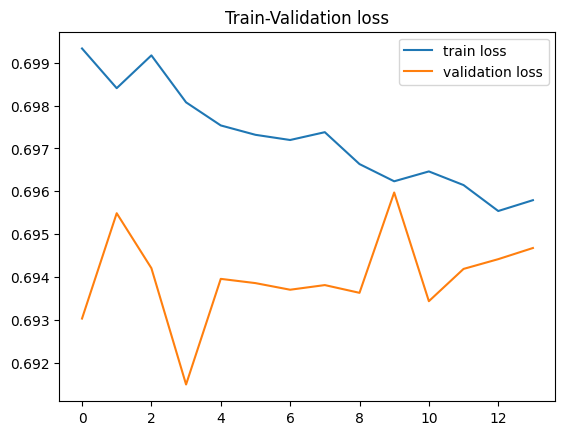

In [40]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_to3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [41]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8575, 'male': 0.234375, 'average': 0.5459375}
precision {'female': 0.5384615384615384, 'male': 0.6122448979591837, 'average': 0.5753532182103611}
f1 {'female': 0.6615236258437801, 'male': 0.33898305084745767, 'average': 0.5002533383456189}
accuracy 0.5522959183673469


Evaluación en el conjunto el conjunto to
recall {'female': 0.8293963254593176, 'male': 0.20437956204379562, 'average': 0.5168879437515567}
precision {'female': 0.49144634525660963, 'male': 0.5637583892617449, 'average': 0.5276023672591773}
f1 {'female': 0.6171874999999999, 'male': 0.30000000000000004, 'average': 0.45859374999999997}
accuracy 0.5050505050505051


Evaluación en el conjunto el conjunto as
recall {'female': 0.8517520215633423, 'male': 0.18181818181818182, 'average': 0.5167851016907621}
precision {'female': 0.49375, 'male': 0.5669291338582677, 'average': 0.5303395669291339}
f1 {'female': 0.6251236399604352, 'male': 0.2753346080305928, 'average'

Resultados finales

In [42]:

for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.5128309973797369
f1 etiqueta male: 0.38399991633430225
f1 etiqueta female:  0.6416620784251715


TO
Resultado global f1: 0.49086953251041876
f1 etiqueta male: 0.3782646080700024
f1 etiqueta female:  0.6034744569508351


AS
Resultado global f1: 0.4825111972059978
f1 etiqueta male: 0.34979546223178004
f1 etiqueta female:  0.6152269321802155


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5128309973797369
recall etiqueta male: 0.38399991633430225
recall etiqueta female:  0.6416620784251715


TO
Resultado global recall: 0.49086953251041876
recall etiqueta male: 0.3782646080700024
recall etiqueta female:  0.6034744569508351


AS
Resultado global recall: 0.4825111972059978
recall etiqueta male: 0.34979546223178004
recall etiqueta female:  0.6152269321802155


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5128309973797369
precision etiqueta male: 0.38399991633430225
precision etiqueta femal

# AS

In [43]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6963020286908964 	 Validation loss: 0.694116464105703 	 
  1%|          | 574/57400 [02:08<3:21:37,  4.70it/s]
Epoch 2 	 Training loss: 0.694175576395274 	 Validation loss: 0.6942413489697343 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:14<3:21:45,  4.65it/s]
Epoch 3 	 Training loss: 0.6937423422153819 	 Validation loss: 0.6922459794303119 	 
  3%|▎         | 1722/57400 [06:21<3:30:27,  4.41it/s]
Epoch 4 	 Training loss: 0.6934617869945353 	 Validation loss: 0.6932293459520502 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [08:27<3:22:34,  4.53it/s]
Epoch 5 	 Training loss: 0.6931686892534382 	 Validation loss: 0.6924026810516746 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [10:34<3:12:13,  4.73it/s]
Epoch 6 	 Training loss: 0.6932109043988617 	 Validation loss: 0.6931693341772435 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [12:40<3:09:27,  4.75it/s]
Epoch 7 	 Training loss: 0.6931851130329358 	 V

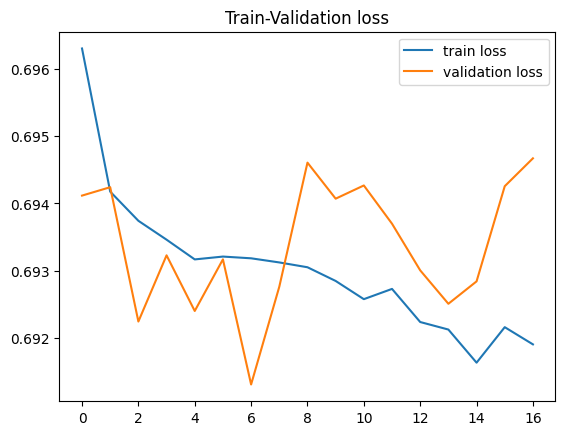

In [44]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_as'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [45]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.9025, 'male': 0.19791666666666666, 'average': 0.5502083333333333}
precision {'female': 0.5396113602391629, 'male': 0.6608695652173913, 'average': 0.6002404627282771}
f1 {'female': 0.6753975678203928, 'male': 0.3046092184368737, 'average': 0.4900033931286333}
accuracy 0.5573979591836735


Evaluación en el conjunto el conjunto to
recall {'female': 0.9081364829396326, 'male': 0.1678832116788321, 'average': 0.5380098473092323}
precision {'female': 0.502906976744186, 'male': 0.6634615384615384, 'average': 0.5831842576028623}
f1 {'female': 0.6473339569691301, 'male': 0.26796116504854367, 'average': 0.45764756100883686}
accuracy 0.523989898989899


Evaluación en el conjunto el conjunto as
recall {'female': 0.9326145552560647, 'male': 0.12626262626262627, 'average': 0.5294385907593455}
precision {'female': 0.5, 'male': 0.6666666666666666, 'average': 0.5833333333333333}
f1 {'female': 0.6509877704609596, 'male': 0.2123142250530785

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6973352327371724 	 Validation loss: 0.6921516293186253 	 
  1%|          | 574/57400 [02:06<3:15:00,  4.86it/s]
Epoch 2 	 Training loss: 0.6947391078862579 	 Validation loss: 0.6950838555723934 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:13<3:18:08,  4.73it/s]
Epoch 3 	 Training loss: 0.6945663659414764 	 Validation loss: 0.6931431929943925 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [06:19<3:13:16,  4.80it/s]
Epoch 4 	 Training loss: 0.6940466864391487 	 Validation loss: 0.693349526090137 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [08:26<3:16:21,  4.68it/s]
Epoch 5 	 Training loss: 0.6937032318073698 	 Validation loss: 0.6922545998783435 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [10:32<3:15:12,  4.66it/s]
Epoch 6 	 Training loss: 0.6936451599573009 	 Validation loss: 0.6919857263565063 	 
  6%|▌         | 3444/57400 [12:39<2:42:41,  5.53it/s]
Epoch 7 	 Training loss: 0.6932569018432072 	 

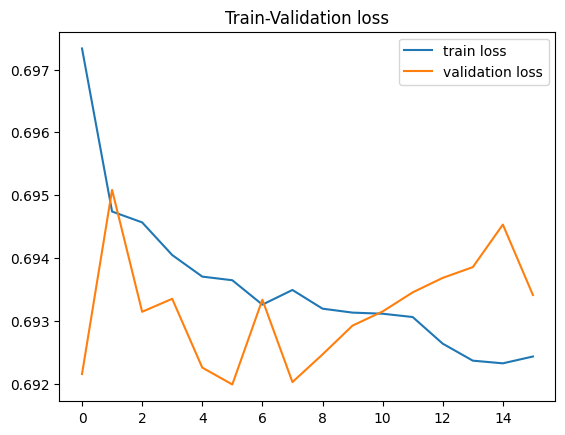

In [46]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_as2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [47]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.92, 'male': 0.0703125, 'average': 0.49515625}
precision {'female': 0.5075862068965518, 'male': 0.4576271186440678, 'average': 0.4826066627703098}
f1 {'female': 0.6542222222222224, 'male': 0.1218961625282167, 'average': 0.3880591923752195}
accuracy 0.5038265306122449


Evaluación en el conjunto el conjunto to
recall {'female': 0.9396325459317585, 'male': 0.08029197080291971, 'average': 0.5099622583673391}
precision {'female': 0.48641304347826086, 'male': 0.5892857142857143, 'average': 0.5378493788819876}
f1 {'female': 0.6410026857654432, 'male': 0.14132762312633831, 'average': 0.39116515444589073}
accuracy 0.4936868686868687


Evaluación en el conjunto el conjunto as
recall {'female': 0.954177897574124, 'male': 0.06060606060606061, 'average': 0.5073919790900923}
precision {'female': 0.48760330578512395, 'male': 0.5853658536585366, 'average': 0.5364845797218303}
f1 {'female': 0.6453965360072926, 'male': 0.10983981693363844

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6976816834888392 	 Validation loss: 0.6923964518611714 	 
  1%|          | 574/57400 [02:06<3:19:11,  4.75it/s]
Epoch 2 	 Training loss: 0.6953541420478023 	 Validation loss: 0.6935404539108276 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:12<3:33:15,  4.40it/s]
Epoch 3 	 Training loss: 0.6946253824317081 	 Validation loss: 0.6918212640083442 	 
  3%|▎         | 1722/57400 [06:19<3:19:49,  4.64it/s]
Epoch 4 	 Training loss: 0.6941586793092069 	 Validation loss: 0.6923689589662066 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [08:25<3:24:36,  4.49it/s]
Epoch 5 	 Training loss: 0.6939408753184076 	 Validation loss: 0.6935043143013776 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [10:32<2:39:18,  5.70it/s]
Epoch 6 	 Training loss: 0.6933448763259197 	 Validation loss: 0.6921536336510868 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [12:38<2:38:45,  5.66it/s]
Epoch 7 	 Training loss: 0.6939312516604567 	

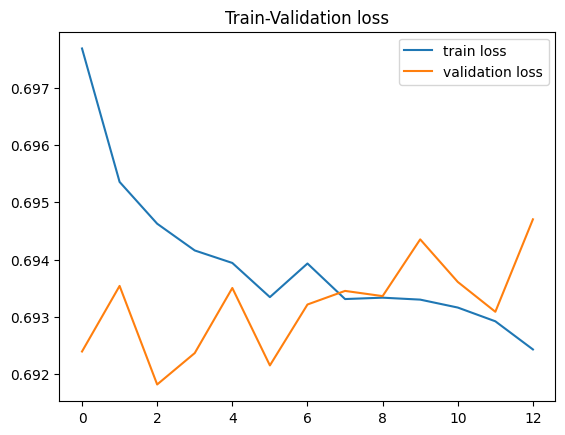

In [48]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_as3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [49]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.81, 'male': 0.21354166666666666, 'average': 0.5117708333333334}
precision {'female': 0.5175718849840255, 'male': 0.5189873417721519, 'average': 0.5182796133780887}
f1 {'female': 0.6315789473684211, 'male': 0.3025830258302583, 'average': 0.4670809865993397}
accuracy 0.5178571428571429


Evaluación en el conjunto el conjunto to
recall {'female': 0.7611548556430446, 'male': 0.22384428223844283, 'average': 0.49249956894074376}
precision {'female': 0.47619047619047616, 'male': 0.5027322404371585, 'average': 0.4894613583138173}
f1 {'female': 0.5858585858585859, 'male': 0.30976430976430974, 'average': 0.44781144781144777}
accuracy 0.4823232323232323


Evaluación en el conjunto el conjunto as
recall {'female': 0.7574123989218329, 'male': 0.3181818181818182, 'average': 0.5377971085518255}
precision {'female': 0.5099818511796733, 'male': 0.5833333333333334, 'average': 0.5466575922565033}
f1 {'female': 0.6095444685466378, 'male': 0

Resultados finales

In [50]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.4483811907010642
f1 etiqueta male: 0.2430294689317829
f1 etiqueta female:  0.6537329124703455


TO
Resultado global f1: 0.43220805442205845
f1 etiqueta male: 0.23968436597973058
f1 etiqueta female:  0.6247317428643864


AS
Resultado global f1: 0.4399745871473267
f1 etiqueta male: 0.24463958262302332
f1 etiqueta female:  0.63530959167163


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.4483811907010642
recall etiqueta male: 0.2430294689317829
recall etiqueta female:  0.6537329124703455


TO
Resultado global recall: 0.43220805442205845
recall etiqueta male: 0.23968436597973058
recall etiqueta female:  0.6247317428643864


AS
Resultado global recall: 0.4399745871473267
recall etiqueta male: 0.24463958262302332
recall etiqueta female:  0.63530959167163


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.4483811907010642
precision etiqueta male: 0.2430294689317829
precision etiqueta female:  0